In [913]:
# Jamie attempts to Reduce RHO data
# Code is all going to be stolen from Adam's 3722, Corin's code for Jason's class, etc

In [914]:
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats, mad_std
from astropy.visualization import ZScaleInterval, ImageNormalize
import astropy.time as time
import matplotlib.pyplot as plt
import numpy as np
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from photutils import datasets
from photutils import DAOStarFinder, find_peaks
from skimage.registration import optical_flow_ilk
from scipy.ndimage import interpolation as interp
import os
import warnings
import glob

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
import astropy.units as u

import sys
from astropy import time

sys.path.append('..')
#import francisco as fr

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [12, 9]

/tmp/ipykernel_38119/3375360987.py:8: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/tmp/ipykernel_38119/3375360987.py:8: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import aperture_photometry, CircularAperture, CircularAnnulus
/tmp/ipykernel_38119/3375360987.py:8: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this wa

In [915]:
# Identify all of the folders that files are in
# set target name

In [916]:
darkfolder='2023-06-29'
biasfolder='2023-06-29'
flatfolder='2023-06-29'
datafolder='2023-06-28'
Target='TIC37660642'

In [917]:
#use Adam's glob thing to collect all the data

In [918]:
data=glob.glob(datafolder+"/"+Target+"*.fits")
data

['2023-06-28/TIC376606423.2023-06-28T22:58:59.080.0029.fits',
 '2023-06-28/TIC376606423.2023-06-28T23:01:33.665.0030.fits',
 '2023-06-28/TIC376606423.2023-06-28T23:04:08.230.0031.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:48:40.790.0025.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:51:15.383.0026.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:43:32.596.0023.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:46:07.156.0024.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:40:58.937.0022.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:56:24.532.0028.fits',
 '2023-06-28/TIC376606423.2023-06-28T22:53:49.930.0027.fits',
 '2023-06-28/TIC376606423.2023-06-28T23:06:41.135.0032.fits']

In [919]:
#check the headers
# EXPTIME exists, but I don't see anything like a gain value. 
#great because I don't really understand gain anyway, so we'll ignore that for now
# FILTER will likely also be helpful at some point

In [920]:
headercheck=fits.getheader('2023-06-28/TIC376606423.2023-06-28T22:58:59.080.0029.fits')
headercheck

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1117 / length of data axis 1                          
NAXIS2  =                  844 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'SBIG CCD'           / CCD Name                                       
TELESCOP= 'Telescope Simulator' / Telescope name                                
OBSERVER= 'JAMIE   '           / Observer name                                  
OBJECT  = 'TIC376606423'    

In [921]:
# to make this general, eventually we'll want to identify how long the data exposure times are here
# and then write code to check whether darks/flats for that time exist
# and select only those
# or if the right times don't exist
# then we do an interpolation to those values of what we do have. 
# for now we'll hard code it and ignore that bit

In [922]:
data_timeseries=[fits.getdata(x) for x in data]
data_timeseries_exptime=[fits.getheader(x)['EXPTIME'] for x in data]
data_timeseries_filter=[fits.getheader(x)['FILTER'] for x in data]
data_timeseries_obstimes=[fits.getheader(x)['DATE-OBS'] for x in data]

In [923]:

for i in range(len(data_timeseries_obstimes)):
    t=time.Time(data_timeseries_obstimes[i])
    t.jd
    data_timeseries_obstimes[i]=t.jd

In [924]:
exptimes=np.unique(data_timeseries_exptime)
filters=np.unique(data_timeseries_filter)
print(int(exptimes))
exptimes1=str((int(exptimes)))
print("/dark"+exptimes1+"*.fits")

150
/dark150*.fits


In [925]:
datadarks = glob.glob(darkfolder+"/dark"+exptimes1+"*.fits")
datadarks

['2023-06-29/dark150s.2023-06-29T00:18:11.168.0018.fits',
 '2023-06-29/dark150s.2023-06-29T00:25:53.170.0019.fits']

In [926]:
print (str(filters))
filters="g" 
# fixing the upper case- lower case issue by hand for now, but need code for that in the long term

['G']


In [927]:
flats = glob.glob(flatfolder+"/Flats_-_"+filters+"*.fits")
flats

['2023-06-29/Flats_-_g.2023-06-29T00:08:59.092.0005.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:09:18.556.0006.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:11:22.256.0010.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:11:59.901.0011.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:08:39.549.0004.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:10:46.820.0009.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:09:37.962.0007.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:09:56.381.0008.fits']

In [928]:
flats_timeseries=[fits.getdata(x) for x in flats]
flats_timeseries_exptime=[fits.getheader(x)['EXPTIME'] for x in flats]
flats_timeseries_filter=[fits.getheader(x)['FILTER'] for x in flats]
print(flats_timeseries_exptime)
flats_timeseries_filter

[15.0, 15.0, 25.0, 25.0, 15.0, 25.0, 15.0, 15.0]


['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']

In [929]:
#why would you do this to me. for now only using the 15 sec ones
flats15=flats[0]
flats15=[flats[0], flats[1], flats[4], flats[6],flats[7]]
flats15

['2023-06-29/Flats_-_g.2023-06-29T00:08:59.092.0005.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:09:18.556.0006.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:08:39.549.0004.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:09:37.962.0007.fits',
 '2023-06-29/Flats_-_g.2023-06-29T00:09:56.381.0008.fits']

In [930]:
flats15_timeseries=[fits.getdata(x) for x in flats15]
flats15_timeseries_exptime=[fits.getheader(x)['EXPTIME'] for x in flats15]
flats15_timeseries_filter=[fits.getheader(x)['FILTER'] for x in flats15]
print(flats15_timeseries_exptime)
flats15_timeseries_filter

[15.0, 15.0, 15.0, 15.0, 15.0]


['G', 'G', 'G', 'G', 'G']

In [931]:
flatexptimes1=str(int(np.unique(flats15_timeseries_exptime)))
print(flatexptimes1)

15


In [932]:
flatdarks15 = glob.glob(darkfolder+"/dark"+flatexptimes1+"s*.fits")
flatdarks15

['2023-06-29/dark15s.2023-06-29T00:15:14.962.0016.fits',
 '2023-06-29/dark15s.2023-06-29T00:15:34.519.0017.fits',
 '2023-06-29/dark15s.2023-06-29T00:14:55.402.0015.fits']

In [933]:
#read in darks

In [934]:
datadarks_timeseries=[fits.getdata(x) for x in datadarks]
flatdarks15_timeseries=[fits.getdata(x) for x in flatdarks15]

In [935]:
mean_datadarks = np.mean(datadarks_timeseries, axis=0)
stddev_datadarks = np.std(datadarks_timeseries, axis=0)
readnoise_datadarks = np.mean(stddev_datadarks)
mean_datadarks_noise = readnoise_datadarks / np.sqrt(len(datadarks))
mean_datadarks_noise

20.32186822665548

In [936]:
import pylab as pl
pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')

(array([9.31468e+05, 5.91600e+03, 2.21200e+03, 1.29700e+03, 6.15000e+02,
        4.07000e+02, 2.03000e+02, 1.36000e+02, 8.40000e+01, 6.10000e+01,
        5.60000e+01, 5.00000e+01, 2.90000e+01, 2.20000e+01, 1.30000e+01,
        1.60000e+01, 9.00000e+00, 1.10000e+01, 8.00000e+00, 8.00000e+00,
        8.00000e+00, 4.00000e+00, 8.00000e+00, 6.00000e+00, 3.00000e+00,
        2.00000e+00, 3.00000e+00, 8.00000e+00, 7.00000e+00, 1.00000e+00,
        6.00000e+00, 3.00000e+00, 2.00000e+00, 3.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 3.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 5.00000e+00, 4.50000e+01]),
 array([  622.5,  1916.5,  3210.5,  4504.5,  5798.5,  7092.5,  8386.5,
         9680.5, 10974.5, 12268.5, 13562.5, 14856.5, 16150.5, 17444.5,
        18738.5, 20032.5, 21326.5, 22620.5, 23914.5, 25208.5, 26502.5,
        27796.5, 29090.5, 30384.5, 31678.5, 32972.5, 34

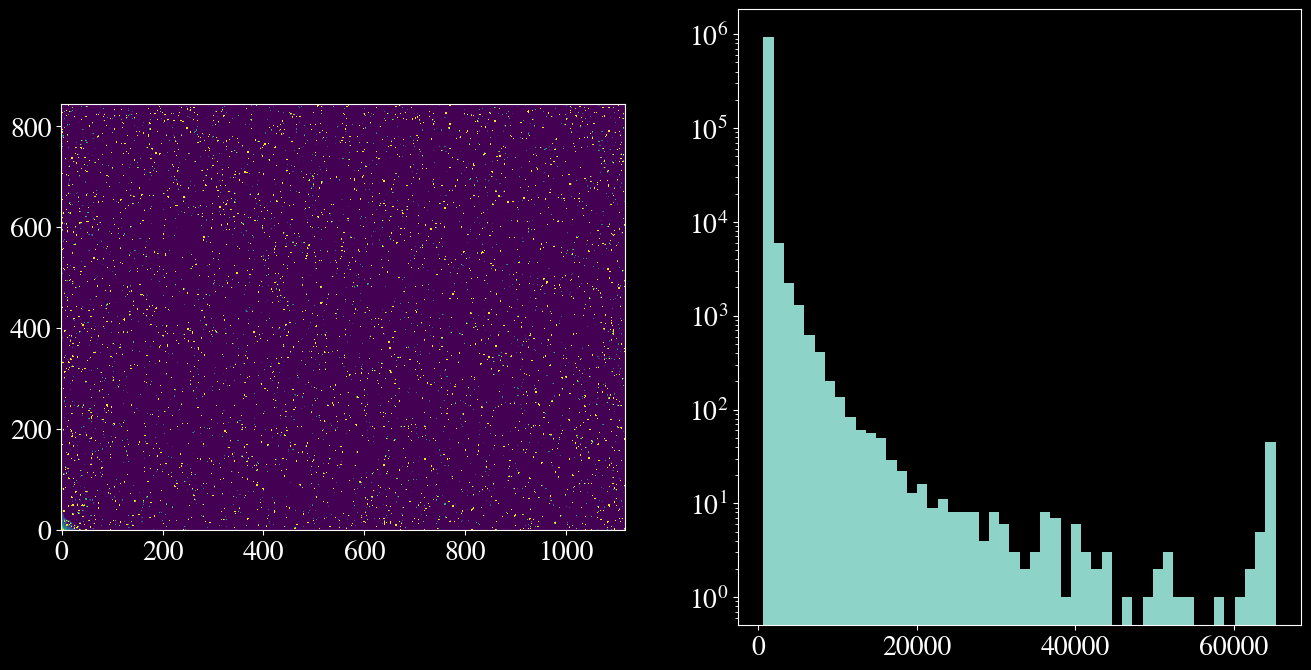

In [937]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(mean_datadarks, origin='lower', vmax=2170, vmin=1860)
pl.subplot(1,2,2).hist(mean_datadarks.ravel(), bins=50, log=True)
#pl.imshow(mean_datadarks, origin='lower')#, vmax=2170, vmin=1860)

(array([9.30881e+05, 6.45400e+03, 2.23100e+03, 1.30100e+03, 6.26000e+02,
        4.07000e+02, 2.10000e+02, 1.40000e+02, 8.20000e+01, 6.60000e+01,
        5.70000e+01, 4.80000e+01, 2.80000e+01, 2.60000e+01, 1.10000e+01,
        1.60000e+01, 1.00000e+01, 9.00000e+00, 9.00000e+00, 8.00000e+00,
        1.00000e+01, 6.00000e+00, 5.00000e+00, 6.00000e+00, 2.00000e+00,
        2.00000e+00, 7.00000e+00, 6.00000e+00, 7.00000e+00, 3.00000e+00,
        4.00000e+00, 3.00000e+00, 3.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 6.00000e+00, 4.50000e+01]),
 array([  608.  ,  1902.24,  3196.48,  4490.72,  5784.96,  7079.2 ,
         8373.44,  9667.68, 10961.92, 12256.16, 13550.4 , 14844.64,
        16138.88, 17433.12, 18727.36, 20021.6 , 21315.84, 22610.08,
        23904.32, 25198.56, 26492.8 , 27787.04, 29081.28, 30375.

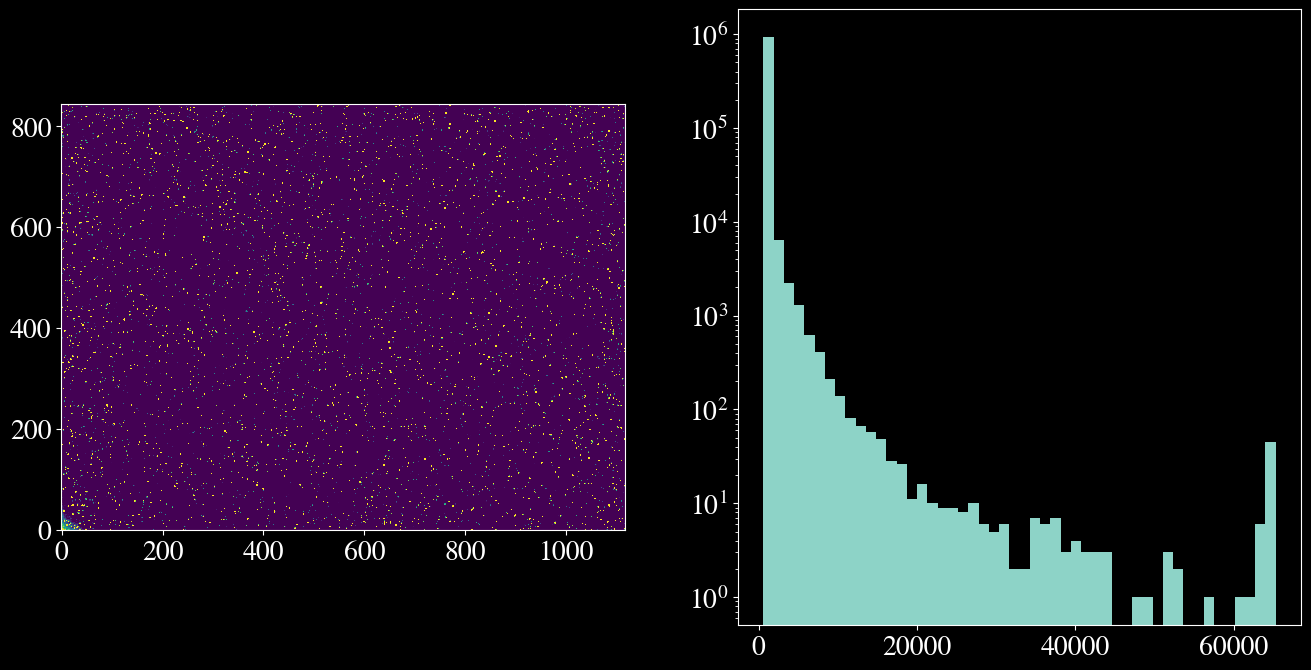

In [938]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(datadarks_timeseries[0], origin='lower', vmax=2170, vmin=1860)
pl.subplot(1,2,2).hist(datadarks_timeseries[0].ravel(), bins=50, log=True)

In [939]:
mean_flatdarks15 = np.mean(flatdarks15_timeseries, axis=0)
stddev_flatdarks15 = np.std(flatdarks15_timeseries, axis=0)
readnoise_flatdarks15 = np.mean(stddev_flatdarks15)
mean_flatdarks15_noise = readnoise_flatdarks15 / np.sqrt(len(flatdarks15))
mean_flatdarks15_noise

19.592555890971653

In [940]:
mean_flats15 = np.mean(flats15_timeseries, axis=0)
mean_flats15


array([[11477.2, 11413.6, 11443.2, ..., 10175. , 10410.8, 10295.8],
       [11349.4, 11501.4, 11430.6, ..., 10223.6, 10185.2, 10256.8],
       [11417.2, 11339.8, 11237.2, ..., 10145.8, 10254.2, 11281.6],
       ...,
       [10282. , 10323. , 10359.2, ...,  9342.6,  9379.8,  9316.8],
       [10348. , 10338. , 10123.4, ...,  9260.2,  9289. ,  9324.2],
       [10365.8, 10250.2, 10240.4, ...,  9207.2,  9409.2,  9259.8]])

(array([1.39010e+04, 4.32165e+05, 4.73704e+05, 2.27650e+04, 9.40000e+01,
        3.80000e+01, 1.60000e+01, 8.00000e+00, 7.00000e+00, 6.00000e+00,
        4.00000e+00, 7.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 4.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.00000e+00]),
 array([ 7685. ,  8837.6,  9990.2, 11142.8, 12295.4, 13448. , 14600.6,
        15753.2, 16905.8, 18058.4, 19211. , 20363.6, 21516.2, 22668.8,
        23821.4, 24974. , 26126.6, 27279.2, 28431.8, 29584.4, 30737. ,
        31889.6, 33042.2, 34194.8, 35347.4, 36500. , 37

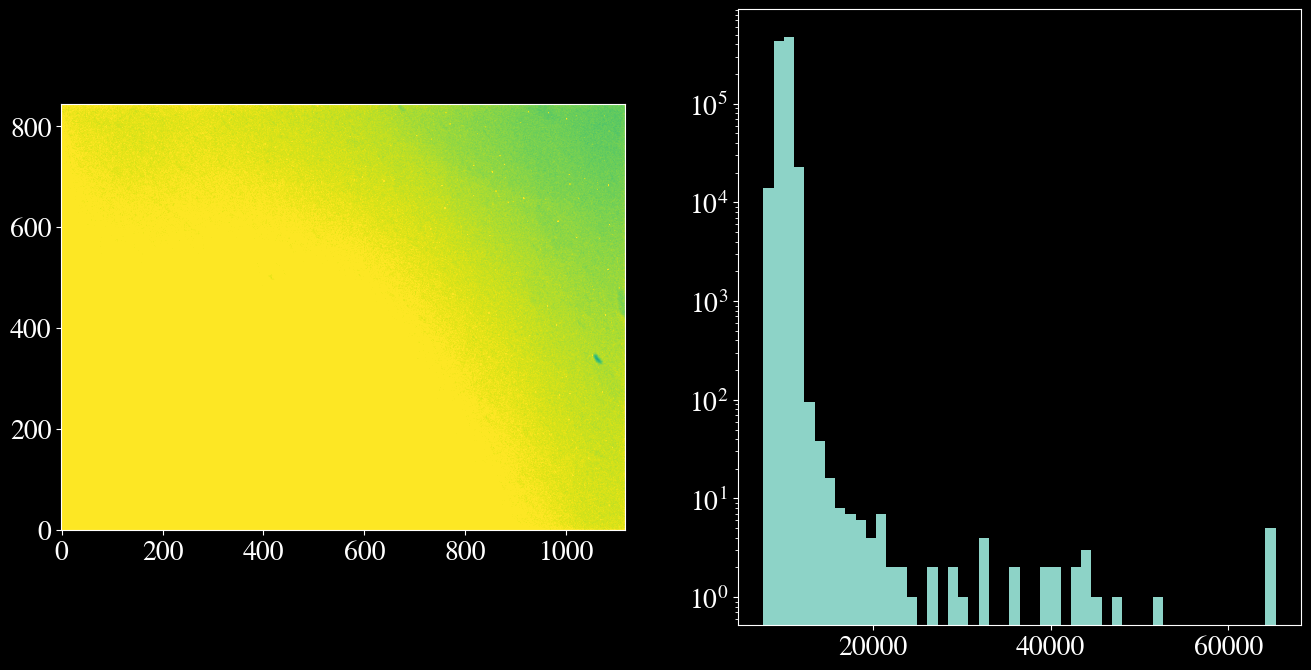

In [941]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(flats15_timeseries[0], origin='lower', vmax=10000, vmin=5000)
pl.subplot(1,2,2).hist(flats15_timeseries[0].ravel(), bins=50, log=True)

In [942]:
#ugh given the low counts here we probably should be using the 25 sec flats but ughhhhh i'm not fixing that now. 
# come back to that later

In [943]:
darksubtracted_flats= mean_flats15 - mean_flatdarks15


In [944]:
mean_of_darksubtracted_flat15 = np.mean(darksubtracted_flats)
mean_of_darksubtracted_flat15

8943.1208907718

In [945]:
normalized_mean_of_darksubtracted_flat = darksubtracted_flats / mean_of_darksubtracted_flat15
np.mean(normalized_mean_of_darksubtracted_flat)

1.0

In [946]:
# actually process the data
# subtract data darks 
# then divide by the dark subtracted and normalized flat
# note that I haven't done anything for cosmic ray rejection, so let's just hope i'm getting lucky lol

In [947]:
darksubtracted_data_timeseries = data_timeseries - mean_datadarks


(array([1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        2.00000e+00, 5.50000e+01, 1.34339e+05, 8.07813e+05, 1.27000e+02,
        6.00000e+01, 4.40000e+01, 3.90000e+01, 2.70000e+01, 2.60000e+01,
        3.00000e+01, 1.30000e+01, 2.30000e+01, 1.70000e+01, 7.00000e+00,
        5.00000e+00, 7.00000e+00, 1.10000e+01, 5.00000e+00, 5.00000e+00,
        5.00000e+00, 4.00000e+00, 1.10000e+01, 5.00000e+00, 6.00000e+00,
        7.00000e+00, 8.00000e+00, 7.00000e+00, 1.00000e+01, 2.60000e+01]),
 array([-48017.5 , -45779.61, -43541.72, -41303.83, -39065.94, -36828.05,
        -34590.16, -32352.27, -30114.38, -27876.49, -25638.6 , -23400.71,
        -21162.82, -18924.93, -16687.04, -14449.15, -12211.26,  -9973.37,
         -7735.48,  -5497.59,  -3259.7 ,  -102

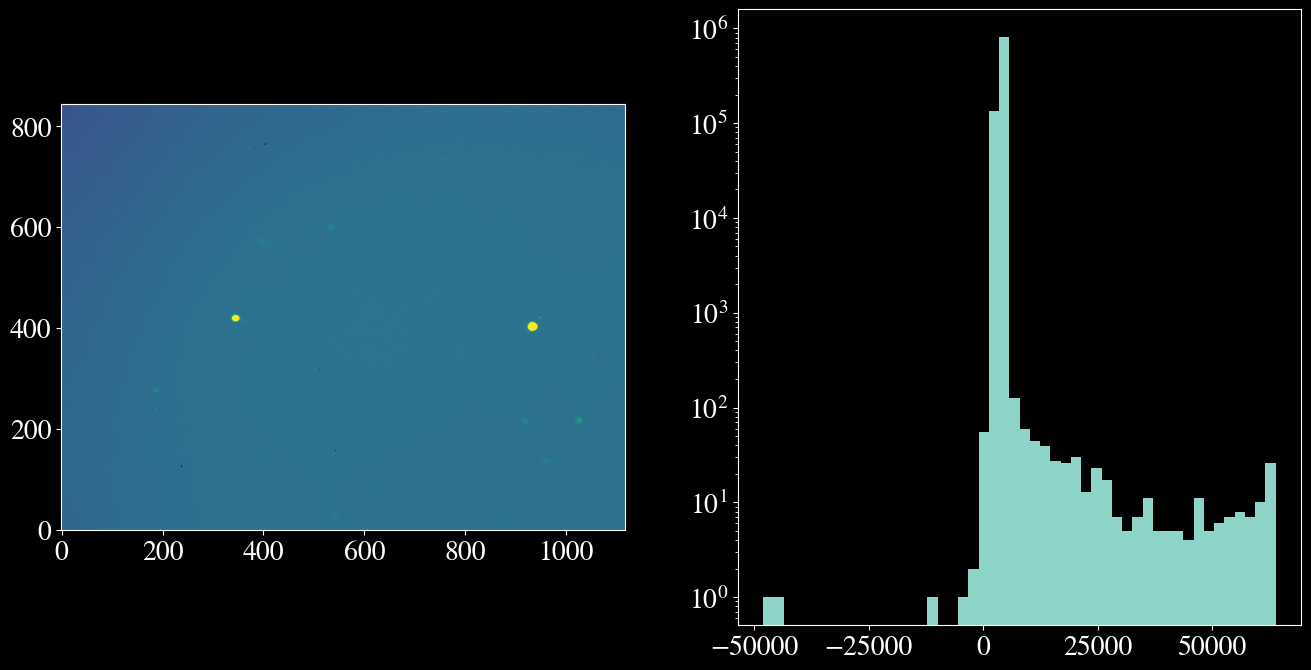

In [948]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(darksubtracted_data_timeseries[0], origin='lower', vmax=10000, vmin=100)
pl.subplot(1,2,2).hist(darksubtracted_data_timeseries[0].ravel(), bins=50, log=True)

In [949]:
data_timeseries_darksub_flattened = darksubtracted_data_timeseries / normalized_mean_of_darksubtracted_flat

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        4.80000e+01, 3.68790e+04, 9.05195e+05, 2.11000e+02, 5.90000e+01,
        4.20000e+01, 4.00000e+01, 3.30000e+01, 2.30000e+01, 3.40000e+01,
        1.60000e+01, 1.60000e+01, 9.00000e+00, 1.10000e+01, 6.00000e+00,
        7.00000e+00, 6.00000e+00, 7.00000e+00, 7.00000e+00, 5.00000e+00,
        4.00000e+00, 1.00000e+01, 5.00000e+00, 6.00000e+00, 4.00000e+00,
        1.10000e+01, 7.00000e+00, 8.00000e+00, 6.00000e+00, 2.50000e+01]),
 array([-48285.95445753, -45948.52898151, -43611.10350549, -41273.67802947,
        -38936.25255345, -36598.82707743, -34261.40160141, -31923.97612539,
        -29586.55064937, -27249.12517335, -24911.69969733, -22574.27422131,
        -20236.84874529, -17899.42326927

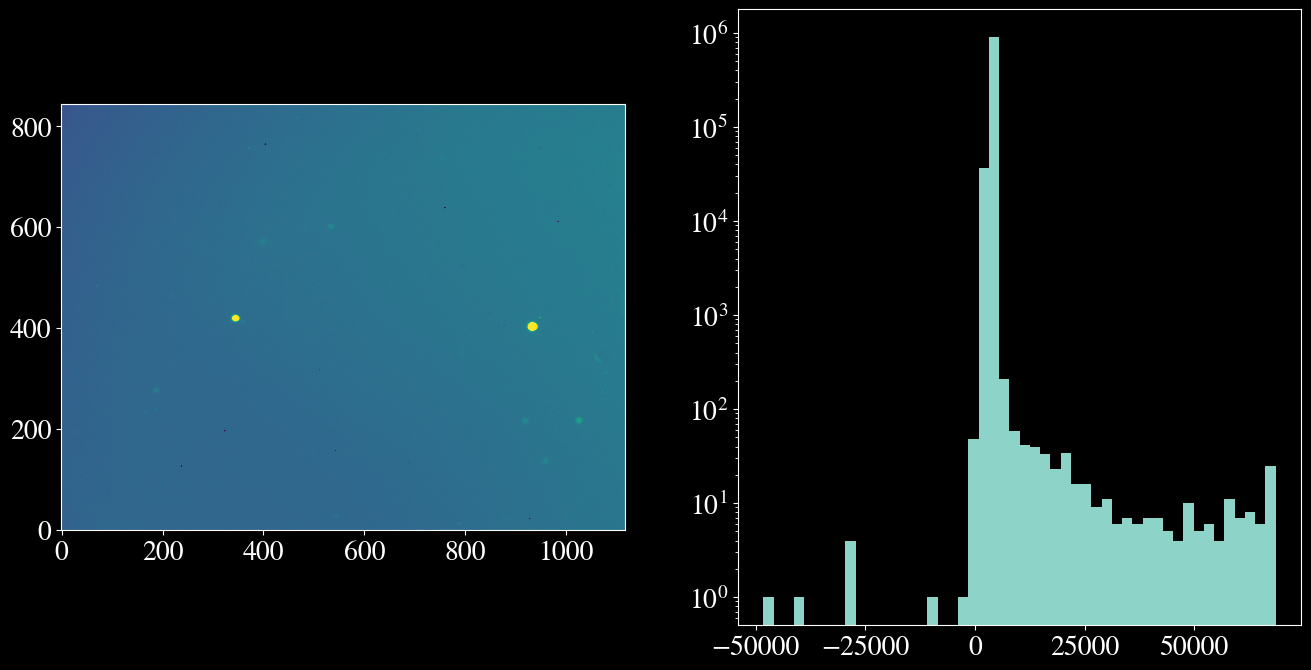

In [950]:
pl.figure(figsize=(16,8))
pl.subplot(1,2,1).imshow(data_timeseries_darksub_flattened[0], origin='lower', vmax=10000, vmin=100)
pl.subplot(1,2,2).hist(data_timeseries_darksub_flattened[0].ravel(), bins=50, log=True)

In [951]:
#honestly the one with the flat divided out looks worse to me. 
#Not sure why. We'll use it for now but we may have to go back and fix later

In [952]:
#okay at this point we have a processed timeseries of data that has stars in it

In [953]:
from photutils.aperture import aperture_photometry, CircularAperture

In [954]:
print(data_timeseries_obstimes)

[2460124.622543449, 2460124.624331655, 2460124.6261244677, 2460124.615392882, 2460124.6171741784, 2460124.6118257293, 2460124.613607072, 2460124.610039838, 2460124.6207553125, 2460124.618964757, 2460124.6278965045]


In [955]:
#steal from photutils(1)

In [956]:
cx,cy = 1025,215
star_cutout = data_timeseries_darksub_flattened[2,cy-10:cy+10, cx-10:cx+10]

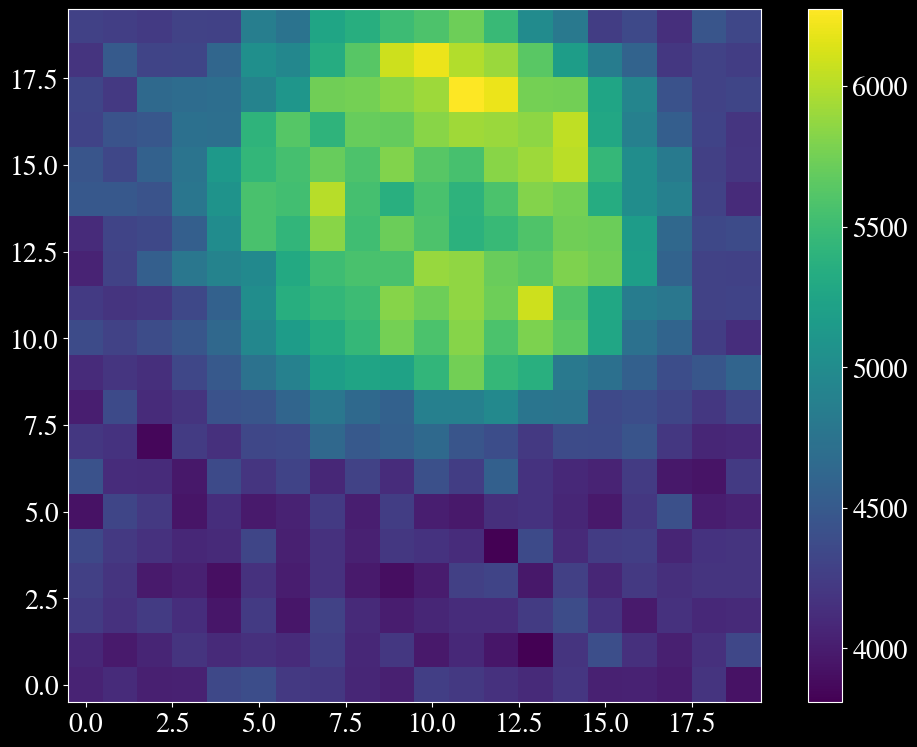

In [957]:
pl.imshow(star_cutout); _=pl.colorbar()

In [958]:
#focus wasn't great, looks a bit donut-y to me. but whatever. 

In [959]:
yc, xc = np.indices(star_cutout.shape)
mom1_x = (xc * star_cutout).sum() / star_cutout.sum()
mom1_y = (yc * star_cutout).sum() / star_cutout.sum()
mom2_x = ((xc - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
mom2_y = ((yc - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
sigma_to_fwhm = np.sqrt(8*np.log(2))
fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
avg_fwhm = (fwhm_x*fwhm_y)**0.5
print(f"FWHM average, in pixels: {avg_fwhm}")

FWHM average, in pixels: 13.28534178315151


In [960]:
#not convinced this code is right, but 13 is approximately the right number of pixels

In [961]:
# estimate the background noise
from astropy.stats import mad_std
background_stddev = mad_std(data_timeseries_darksub_flattened[0])
background_stddev

406.8525831449802

In [962]:
#how we did the aperture photometry for one image

In [963]:
#daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=3.*background_stddev)  
#sources = daofind(data_timeseries_darksub_flattened[0])

In [964]:
#sources.show_in_notebook()

In [965]:

#positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
#apertures = CircularAperture(positions, r=avg_fwhm)  
#phot_table = aperture_photometry(data_timeseries_darksub_flattened[0], apertures)  
#for col in phot_table.colnames:  
#    phot_table[col].info.format = '%.8g'  # for consistent table output
#phot_table

#pl.figure(figsize=(6,6))
#pl.imshow(data_timeseries_darksub_flattened[0], cmap='gray_r', origin='lower', vmax=10000, vmin=200)
#_=apertures.plot(color='blue', lw=1.5, alpha=0.5)

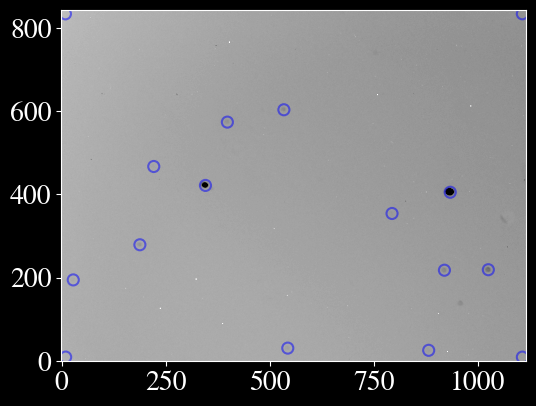

In [966]:
#
daofind = DAOStarFinder(fwhm=avg_fwhm*1.5, threshold=2*background_stddev)  
sources = daofind(data_timeseries_darksub_flattened[2])
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(data_timeseries_darksub_flattened[2], apertures)  
#for col in phot_table.colnames:  
#    phot_table[col].info.format = '%.8g'  # for consistent table output
#phot_table

pl.figure(figsize=(6,6))
pl.imshow(data_timeseries_darksub_flattened[2], cmap='gray_r', origin='lower', vmax=10000, vmin=200)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [967]:
#start stealing corins code 

In [968]:
sig3s = []
for i in range(0,len(data_timeseries_darksub_flattened)):
    sig3s.append(np.std(data_timeseries_darksub_flattened[i])*3.)
print(sig3s)

[2186.23935183076, 2202.8463197890337, 2189.061648395228, 2243.2161711803856, 2237.31973144034, 2222.710664016852, 2241.236644262868, 2182.927465459728, 2227.700237585206, 2208.525142277278, 661.4146953846225]


In [982]:
phot_table_timeseries=np.array(0)
# could probably optimize this by allocating the whole length and then 
#updating values rather than appending
# np.empty(len(data_timeseries_darksub_flattened))?
targ_fluxes = np.array(0)
r1_fluxes=np.array(0)
r2_fluxes=np.array(0)
r3_fluxes=np.array(0)
r4_fluxes=np.array(0)
r5_fluxes=np.array(0)
r1_times=np.array(0)
r2_times=np.array(0)
r3_times=np.array(0)
r4_times=np.array(0)
r5_times=np.array(0)
targ_times=np.array(0)
r1coord=[959,136]
r2coord=[919,215]
r3coord=[1025,216]
r4coord=[188,276]
targ_coord=[345,419]
r5coord=[534,601]


In [970]:
#sig3s=np.std(data_timeseries_darksub_flattened[1])*2.
#daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=sig3s)
#sources = daofind(data_timeseries_darksub_flattened[1])
#positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
#apertures = CircularAperture(positions, r=avg_fwhm)
#annulus_apertures = CircularAnnulus(positions, r_in=avg_fwhm*2, r_out=2*avg_fwhm+10)
#print, positions
#pl.figure(figsize=(6,6))
#pl.imshow(data_timeseries_darksub_flattened[1], cmap='gray_r', origin='lower', vmax=10000, vmin=200)
#_=apertures.plot(color='blue', lw=1.5, alpha=0.5)
#_=annulus_apertures.plot(color='red', lw=1.5, alpha=0.5)

In [971]:
#aperstats = ApertureStats(data_timeseries_darksub_flattened[1], annulus_apertures)
#bkg_means = aperstats.mean
#phot_table = aperture_photometry(data_timeseries_darksub_flattened[1], apertures)
#aperture_areas = apertures.area
#total_bkgs = bkg_means * aperture_areas
#phot_bkgsub = phot_table['aperture_sum'] - total_bkgs
#print(phot_bkgsub)

In [987]:
centershiftallowance=20 #pixels i think
for i in range(0,len(data_timeseries_darksub_flattened)):
    sig3s=np.std(data_timeseries_darksub_flattened[i])*2.
    daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=sig3s)
    sources = daofind(data_timeseries_darksub_flattened[i])
    #print(sources)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=avg_fwhm)  
# corin has some code that might do local background subtraction
    annulus_apertures = CircularAnnulus(positions, r_in=avg_fwhm, r_out=avg_fwhm+10)
    aperstats = ApertureStats(data_timeseries_darksub_flattened[i], annulus_apertures)
    bkg_means = aperstats.mean
    phot_table1 = aperture_photometry(data_timeseries_darksub_flattened[i], apertures) 
    aperture_areas = apertures.area
    total_bkgs = bkg_means * aperture_areas
    phot_table1['bksub'] = phot_table1['aperture_sum'] - total_bkgs   
    for col in phot_table1.colnames:  
        phot_table1[col].info.format = '%.8g'  # for consistent table output
    phot_table_timeseries=[phot_table_timeseries,phot_bkgsub]
    phot_table=np.array(phot_table1)


#I'm having trouble dealing with the whole table all at once, so I'm going to do something dumb instead
    for j in range(len(phot_table)):
  #      print(abs(phot_table['xcenter'][j]-r1coord[0]),  abs(phot_table['ycenter'][j]-r1coord[1]))
        if (abs(phot_table['xcenter'][j]-r2coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r2coord[1])<centershiftallowance):
            r2_fluxes=np.append(r2_fluxes, phot_table['bksub'][j])
            r2_times=np.append(r2_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r1coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r1coord[1])<centershiftallowance):
            r1_fluxes=np.append(r1_fluxes, phot_table['bksub'][j])
            r1_times=np.append(r1_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r3coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r3coord[1])<centershiftallowance):
            r3_fluxes=np.append(r3_fluxes, phot_table['bksub'][j])
            r3_times=np.append(r3_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r4coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r4coord[1])<centershiftallowance):
            r4_fluxes=np.append(r4_fluxes, phot_table['bksub'][j])
            r4_times=np.append(r4_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r5coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r5coord[1])<centershiftallowance):
            r5_fluxes=np.append(r5_fluxes, phot_table['bksub'][j])
            r5_times=np.append(r5_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-targ_coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-targ_coord[1])<centershiftallowance):
            targ_fluxes=np.append(targ_fluxes, phot_table['bksub'][j])
            targ_times=np.append(targ_times, data_timeseries_obstimes[i])

#version WITHOUT annulus correction
centershiftallowance=20 #pixels i think
for i in range(0,len(data_timeseries_darksub_flattened)):
    sig3s=np.std(data_timeseries_darksub_flattened[i])*2.
    daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=sig3s)
    sources = daofind(data_timeseries_darksub_flattened[i])
    #print(sources)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=avg_fwhm)  
# corin has some code that might do local background subtraction
    annulus_apertures = CircularAnnulus(positions, r_in=avg_fwhm, r_out=avg_fwhm+10)
    aperstats = ApertureStats(data_timeseries_darksub_flattened[i], annulus_apertures)
    bkg_means = aperstats.mean
    phot_table1 = aperture_photometry(data_timeseries_darksub_flattened[i], apertures) 
    aperture_areas = apertures.area
    total_bkgs = bkg_means * aperture_areas
    phot_table1['bksub'] = phot_table1['aperture_sum'] - total_bkgs   
    for col in phot_table1.colnames:  
        phot_table1[col].info.format = '%.8g'  # for consistent table output
    phot_table_timeseries=[phot_table_timeseries,phot_bkgsub]
    phot_table=np.array(phot_table1)


#I'm having trouble dealing with the whole table all at once, so I'm going to do something dumb instead
    for j in range(len(phot_table)):
  #      print(abs(phot_table['xcenter'][j]-r1coord[0]),  abs(phot_table['ycenter'][j]-r1coord[1]))
        if (abs(phot_table['xcenter'][j]-r2coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r2coord[1])<centershiftallowance):
            r2_fluxes=np.append(r2_fluxes, phot_table['aperture_sum'][j])
            r2_times=np.append(r2_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r1coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r1coord[1])<centershiftallowance):
            r1_fluxes=np.append(r1_fluxes, phot_table['aperture_sum'][j])
            r1_times=np.append(r1_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r3coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r3coord[1])<centershiftallowance):
            r3_fluxes=np.append(r3_fluxes, phot_table['aperture_sum'][j])
            r3_times=np.append(r3_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r4coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r4coord[1])<centershiftallowance):
            r4_fluxes=np.append(r4_fluxes, phot_table['aperture_sum'][j])
            r4_times=np.append(r4_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-r5coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-r5coord[1])<centershiftallowance):
            r5_fluxes=np.append(r5_fluxes, phot_table['aperture_sum'][j])
            r5_times=np.append(r5_times, data_timeseries_obstimes[i])
        if (abs(phot_table['xcenter'][j]-targ_coord[0])<centershiftallowance) and (abs(phot_table['ycenter'][j]-targ_coord[1])<centershiftallowance):
            targ_fluxes=np.append(targ_fluxes, phot_table['aperture_sum'][j])
            targ_times=np.append(targ_times, data_timeseries_obstimes[i])

In [973]:
#probably somewhere in this loop we're supposed to subtract the background counts
# from the aperture counts. 
# add that to the 'to fix later' set of things

In [984]:
print(r1_fluxes[1:len(r1_fluxes-1)], r1_times[1:5])

[90141.96288715 89882.7277052  87745.482827   97804.01276767
 83979.32662749] [2460124.62254345 2460124.62433165 2460124.61539288 2460124.61182573]


In [975]:
# here's where i start really hacking for my dataset

In [985]:
r1_times=r1_times[1:len(r1_fluxes)]
r1_fluxes=r1_fluxes[1:len(r1_fluxes)]
r2_times=r2_times[1:len(r2_fluxes)-1]
r2_fluxes=r2_fluxes[1:len(r2_fluxes)-1]
r3_times=r3_times[1:len(r3_fluxes)-1]
r3_fluxes=r3_fluxes[1:len(r3_fluxes)-1]
r4_times=r4_times[1:len(r4_fluxes)-1]
r4_fluxes=r4_fluxes[1:len(r4_fluxes)-1]
r5_times=r5_times[1:len(r5_fluxes)-1]
r5_fluxes=r5_fluxes[1:len(r5_fluxes)-1]
targ_times=targ_times[1:len(targ_fluxes)-1]
targ_fluxes=targ_fluxes[1:len(targ_fluxes)-1]

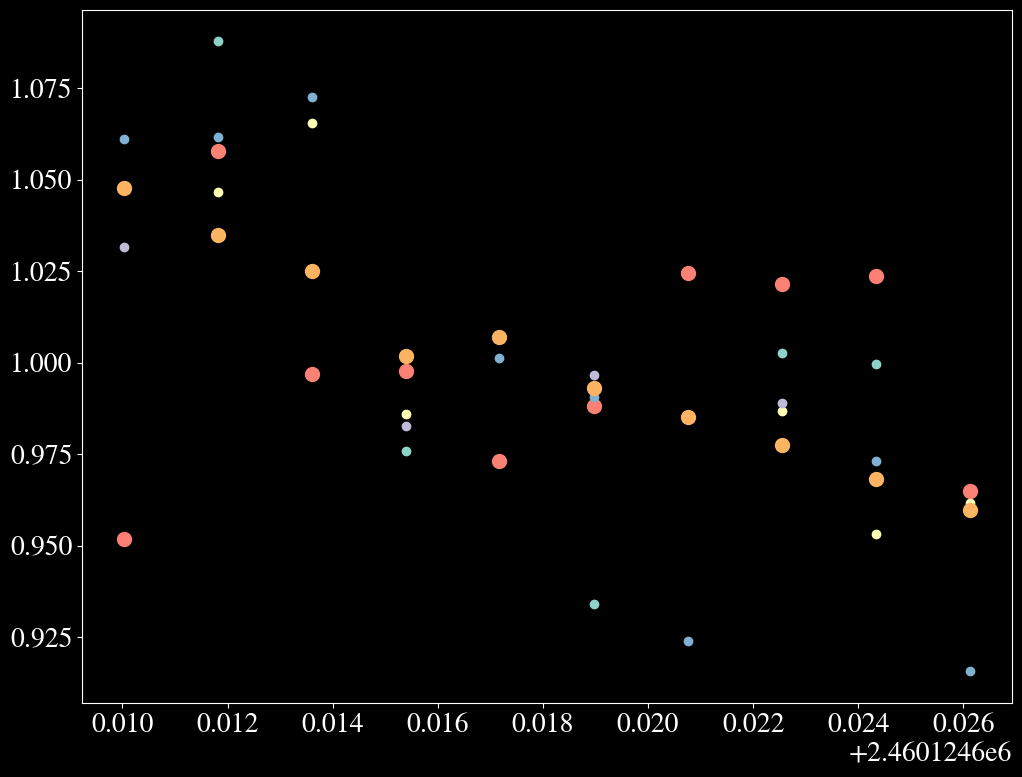

In [986]:
pl.scatter(r1_times, r1_fluxes/np.mean(r1_fluxes))
pl.scatter(r2_times, r2_fluxes/np.mean(r2_fluxes))
pl.scatter(r3_times, r3_fluxes/np.mean(r3_fluxes))
pl.scatter(r4_times, r4_fluxes/np.mean(r4_fluxes), s=100)
pl.scatter(r5_times, r5_fluxes/np.mean(r5_fluxes))
pl.scatter(targ_times, targ_fluxes/np.mean(targ_fluxes), s=100)

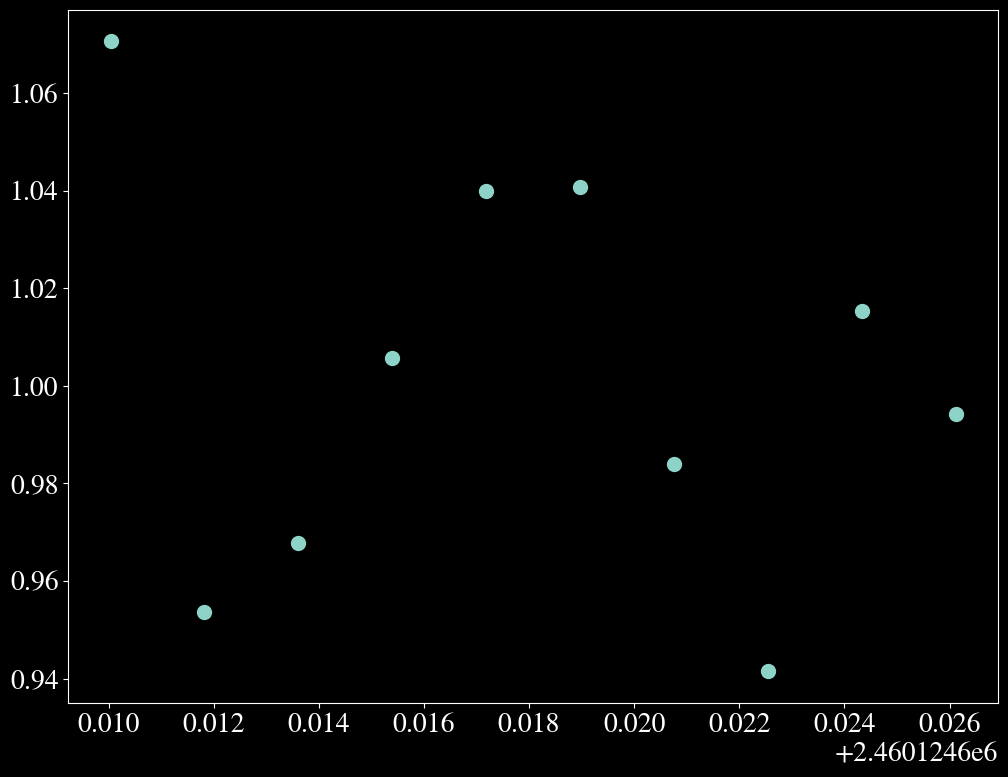

In [978]:
#pl.scatter(r1_times, r1_fluxes/np.mean(r1_fluxes))
#pl.scatter(r2_times, r2_fluxes/np.mean(r2_fluxes))
#pl.scatter(r3_times, r3_fluxes/np.mean(r3_fluxes))
#pl.scatter(r4_times, r4_fluxes/np.mean(r4_fluxes), s=100)
#pl.scatter(r5_times, r5_fluxes/np.mean(r5_fluxes))
pl.scatter(targ_times, (targ_fluxes/np.mean(targ_fluxes))/(r4_fluxes/np.mean(r4_fluxes)), s=100)

In [979]:
print(len(r5_times), len(r4_times), len(r3_times), len(r2_times), len(r1_times), len(targ_times))
print(r5_times)
print(targ_times)

8 10 4 6 5 10
[2460124.62433165 2460124.62612447 2460124.61717418 2460124.61182573
 2460124.61360707 2460124.61003984 2460124.62075531 2460124.61896476]
[2460124.62254345 2460124.62433165 2460124.62612447 2460124.61539288
 2460124.61717418 2460124.61182573 2460124.61360707 2460124.61003984
 2460124.62075531 2460124.61896476]


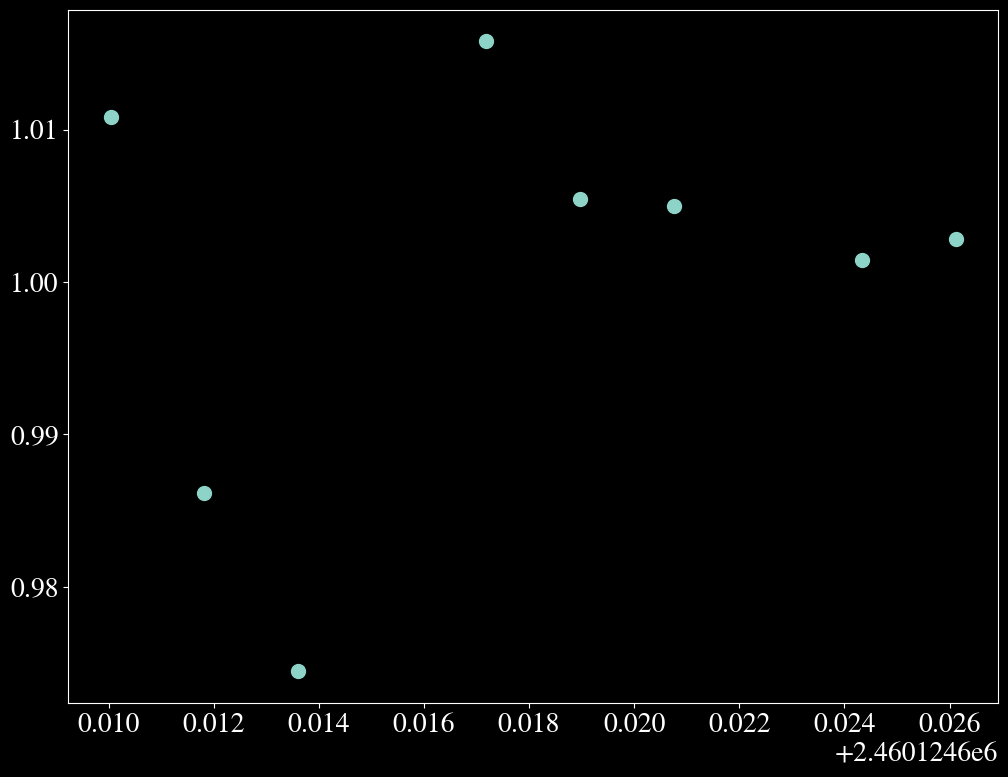

In [980]:
targ_times_5=[targ_times[1], targ_times[2],targ_times[4], targ_times[5],targ_times[6], 
              targ_times[7],targ_times[8], targ_times[9] ]
targ_fluxes_5=[targ_fluxes[1], targ_fluxes[2],targ_fluxes[4], targ_fluxes[5],targ_fluxes[6], 
              targ_fluxes[7],targ_fluxes[8], targ_fluxes[9] ]

r4_times_5=[r4_times[1], r4_times[2],r4_times[4], r4_times[5],r4_times[6], 
              r4_times[7],r4_times[8], r4_times[9] ]
r4_fluxes_5=[r4_fluxes[1], r4_fluxes[2],r4_fluxes[4], r4_fluxes[5],r4_fluxes[6], 
              r4_fluxes[7],r4_fluxes[8], r4_fluxes[9] ]

pl.scatter(targ_times_5, 2*(targ_fluxes_5/np.mean(targ_fluxes_5))/(r4_fluxes_5/np.mean(r4_fluxes_5)+(r5_fluxes/np.mean(r5_fluxes))), s=100)


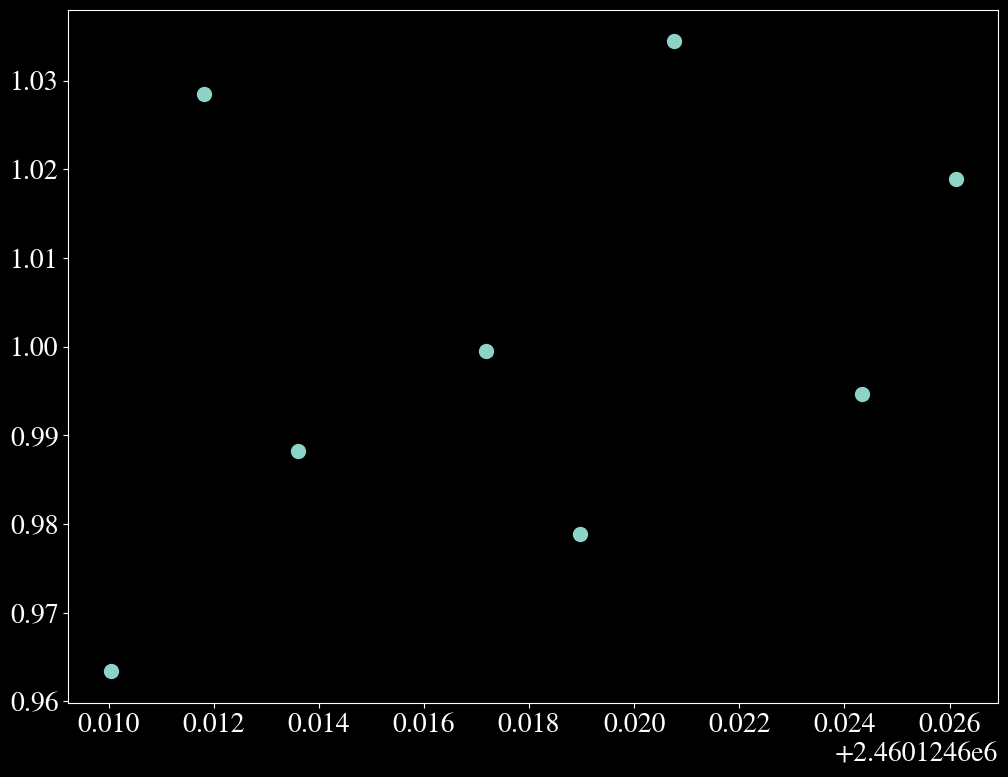

In [981]:
pl.scatter(targ_times_5, (targ_fluxes_5/np.mean(targ_fluxes_5))/((r5_fluxes/np.mean(r5_fluxes))), s=100)
